# Depression and PTSD Detection using Deep Learning

This notebook contains the code to predict *Depression* and *PTSD* based on transcripts of clinical interviews designed to support the diagnosis of psychological distress conditions such as anxiety, depression, and post-traumatic stress disorder.

### Datasets used:
* **DIAC-WOZ:** This dataset consists of Wizard-of-Oz interviews, conducted	by an animated virtual interviewer called Ellie, with Veterans.
* **ANONYMITY:** This dataset consists of Wizard-of-Oz interviews, conducted	by an animated virtual interviewer called Ellie, with Students.


In [1]:
# Important Libraries

import pandas as pd
import torch
import os
import torch.nn as nn
import numpy as np
from collections import Counter
from torch.nn.utils.rnn import pack_padded_sequence
from torchsummary import summary
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

### Paths and Constant Variables:

Following containts paths to both the datasets. In order to train the model we make use of *Glove Embeddings*.

**GloVe:** <br>
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. We are using the embedding file with 840B tokens, 2.2M vocab, consisting of 300d vectors.

*Link:* https://nlp.stanford.edu/projects/glove/

In [2]:
DIAC_WOZ_TRAIN_PATH = 'new-train-split.csv'
DIAC_WOZ_TEST_PATH = 'new-test-split.csv'
DIAC_WOZ_VAL_PATH = 'new-dev-split.csv'

ANONYMITY_DATASET = 'Extra-data.csv'

EMBEDDING_FILE = 'glove.42B.300d.txt'

VOCAB_TO_INDEX = {"":0, "UNK":1}

# Maximum words in one sentence (participant)
SENTENCE_MAX_LEN = 2204

PHQ_MAX_VAL = 23
PTSD_MAX_VAL = 85

# to store model checkpoints and graphical results of the trained model
MODEL_CHECKPOINT = 'model_checkpoints/'
VISUALIZATION = 'results/'

if not os.path.isdir(MODEL_CHECKPOINT):
    os.makedirs(MODEL_CHECKPOINT)
    print("New folder created for checkpoint!")

if not os.path.isdir(VISUALIZATION):
    os.makedirs(VISUALIZATION)
    print("New folder created for results!")

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Important utility functions along with their descriptions:

In [3]:
def get_diacwoz_data(dataset):
    """
    Returns features along with normalized PHQ and PTSD values
    :params: dataset - Train/Test/Validation
    """
    features = dataset.Text
    PHQ = dataset.PHQ8_Score
    PHQ = PHQ/PHQ_MAX_VAL
    PTSD = dataset.PTSD
    PTSD = PTSD/PTSD_MAX_VAL
  
    return features, PHQ, PTSD

def get_anonymity_data(dataset):
    """
    Returns features along with normalized PHQ values
    :params: dataset - Train/Test
    """
    features = dataset.Text
    PHQ = dataset.PHQ8_Score
    PHQ = PHQ/PHQ_MAX_VAL
  
    return features, PHQ

def get_embeddings():
    """
    Returns a dictionary containing words as keys and glove word vectors as values
    """
    embeddings_index = {}
    with open(EMBEDDING_FILE, encoding='utf8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def tokenize_text(text):
    """
    Splits text into list of words
    :params: text - input paragraph
    """
    tokens = []
    for txt in text:
        tokens.append(txt.split())
    return tokens

def encode_sentence(text):
    """
    Converts sentences into numerical representation
    :params: text - input paragraph
    """
    tokenized = tokenize_text([text])
    encoded = np.zeros(SENTENCE_MAX_LEN, dtype=np.float32)
    enc1 = np.array([VOCAB_TO_INDEX.get(word, VOCAB_TO_INDEX["UNK"]) for word in tokenized[0]])
    length = min(SENTENCE_MAX_LEN, len(enc1))
    encoded[:length] = enc1[:length]
    return  encoded, length


def get_emb_matrix(glove_embed, word_counts, emb_size = 300):
    """
    returns weight matrix for embeddings along with vocabulary
    :params: glove_embed - glove dictionary
             word_counts - unique words in dataset
             emb_size - size of the word embeddings
    """

    vocab_size = len(word_counts) + 2 
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    
    i = 2
    for word in word_counts:
        if word in glove_embed:
            W[i] = glove_embed[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        VOCAB_TO_INDEX[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab)

def write_stats(model, filename, epochs, lr, task):
    """
    Creates a text file with details of the model and hyper parameters.
    """
    f = open(VISUALIZATION + filename, 'w+')
    f.write('Model Architecture: \n'+str(model))
    f.write('\nEpochs: '+str(epochs))
    if task == "Single":
        f.write('\nlearning rate: '+str(lr[0]))
    else:
        f.write('\nLearning rate PHQ head: '+str(lr[1]))
        f.write('\nLearning rate Body: '+str(lr[0]))
        
    f.close()

### Performance Statistics Functions:

These functions basically plots the training and validation loss curves to depict the training process of the model, outputs a confusion matrix and classification report to evaluate the models performance on the test dataset

In [21]:
def plot_cm(lab, pred, target_names, title, task, TYPE):
    """
    plots normalized confusion matrix
    :params: lab - actual labels
             pred - predicted labels
             target_names - names of classes
             title - title of plot
             task - name of the task
             TYPE - flag for Binary or tertiary classification of PHQ values
    """
    cm = confusion_matrix(lab, pred)
    print(cm)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap = "YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    if TYPE == "":
        plt.savefig(VISUALIZATION+"{}_confusion_matrix.png".format(task))
    else:
        plt.savefig(VISUALIZATION+"{}_{}_confusion_matrix.png".format(task,TYPE))
    plt.show()
    plt.close()

    
def draw_training_curves(train_losses, test_losses, curve_name, title, epoch):
    plt.clf()
    
    plt.xlim([0,epoch])
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.ylabel(curve_name)
    plt.xlabel('Epoch')
    plt.title(title)
    plt.legend(frameon=False)
    plt.savefig(VISUALIZATION +"{}_curve.png".format(curve_name))
    plt.show()
    plt.close()
    
def print_accuracy(true_label, predicted_label):   
    """
    prints accuracy of the task
    :params: true_label - actual labels of the dataset
             predicted_label - predictions from model
    """
    correct = 0
    total = 0
    for x,y in zip(true_label, predicted_label):
        if x == y:
            correct+=1
        total+=1
        
    print("Accuracy: ", correct/total)
    
def get_classification_report(actual, predicted, labels, target_names, report_name):
    """
    Creates a csv file consisting of f1-score, recall and precision
    """
    report = pd.DataFrame(classification_report(actual, predicted, labels= labels, target_names=target_names, output_dict = True))
    report.to_csv(VISUALIZATION+report_name)
    

### Helper functions to classify range:

The following cell contains the code to classify the output of the PHQ and PTSD values in the following format.

**PHQ**:<br>
* If split variable is set to **Two** then we have a **Binary classification**. <br>
    * If the values are in the range 0 to 10 (un-normalized) or 0 to 0.434 (normalized) then the person has no depression and the label assigned is **No**<br>
    * If the values are in the range 11 to 23 (un-normalized) or 0.478 to 1 (normalized) then the person has depression and the label assigned is **Yes** <br>
* If split variable is set to **Three** then we have a **Tertiary classification**. <br>
    * If the values are in the range 0 to 10 (un-normalized) or 0 to 0.434 (normalized) then the person has no depression and the label assigned is **No**<br>
    * If the values are in the range 11 to 14 (un-normalized) or 0.478 to 0.608 (normalized) then the person has moderate depression and the label assigned is **Moderate** <br> 
    * If the values are in the range 14 to 23 (un-normalized) or 0.702 to 1 (normalized) then the person has severe depression and the label assigned is **Severe** <br> 
    

**PTSD**:<br>
* We have a **Binary classification**. <br>
    * If the values are in the range 0 to 33 (un-normalized) or 0 to 0.39 (normalized) then the person has no PTSD and the label assigned is **No**<br>
    * If the values are in the range 33 to 85 (un-normalized) or 0.39 to 1 (normalized) then the person has PTSD and the label assigned is **Yes** <br>


In [28]:
def classify_phq(label, split):
    """
    converts probabilites into classes
    :params: label - class probabilities (actual/predicted)
             split - 2 way split (yes/no) or 3 way split (no/moderate/severe)
    """
    final_label = []
    
    if split == "Three":
        for val in label:
            if val <=  10:# 0.434:
                final_label.append("No")
            elif val > 10 and val<15:#>0.4340 and val <= 0.608:
                final_label.append("Moderate")
            else:
                final_label.append("Severe")
    else:
        for val in label:
            if val <= 10:#0.434:
                final_label.append("No")
            else:
                final_label.append("Yes")         
    
    return final_label

def classify_ptsd(label):
    """
    converts probabilites into classes
    :params: label - class probabilities (actual/predicted)
    """
    final_label = []
    
    for val in label:
        if val < 34:#0.39:
            final_label.append("No")
        else:
            final_label.append("Yes")
    
    return final_label


[[20  5]
 [ 1 24]]


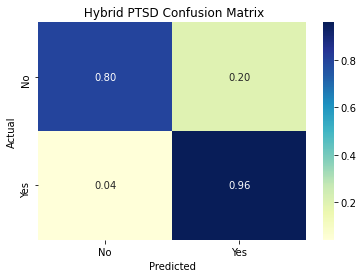

In [33]:
data1 =pd.read_csv('pushk.csv')
actual1 = data1['PTSD'].values
pred1 = data1['Predicted-PTSD-Score'].values
act = classify_ptsd(actual1)
pre = classify_ptsd(pred1)
target_names = [ "No", "Yes"]
title = " Hybrid PTSD Confusion Matrix"
TYPE = ""
task = "PTSD"
plot_cm(act, pre, target_names, title, task, TYPE)

  PCL-C Predicted_PCL  PHQ8_Binary  Predicted-PHQ-binary  PHQ8_Score  \
0    no           yes            0                     0           1   
1    no            no            0                     0           5   
2    no            no            0                     0           0   
3    no           yes            0                     0           2   
4    no            no            0                     0           3   

   Predicted_PHQ  PTSD  Predicted-PTSD-Score  
0              3    17                    10  
1              8    29                    40  
2              2    17                    27  
3              4    20                    32  
4              1    28                    40  
['No', 'No', 'No', 'No', 'No', 'Severe', 'No', 'No', 'No', 'Severe', 'Severe', 'No', 'No', 'Moderate', 'No', 'No', 'No', 'Severe', 'No', 'No', 'Severe', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Moderate', 'Severe', 'No', 'No', 'Severe', 'No', 'No', 'No', 'No'

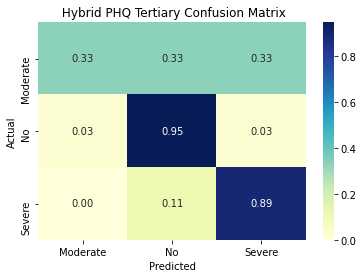

In [30]:
data =pd.read_csv('pushk.csv')
actual = data['PHQ8_Score'].values
pred = data['Predicted_PHQ'].values
t_actual = classify_phq(actual, "Three")
t_pred = classify_phq(pred, "Three")
# t_actual[3] = 'Moderate'
# t_pred[3] = 'Moderate'
# t_actual[48] = 'Moderate'
# t_pred[48] = 'Moderate'

print(t_actual, t_pred)
target_names = ["Moderate", "No", "Severe"]
title = " Hybrid PHQ Tertiary Confusion Matrix"
TYPE = "Tertiary"
task = "PHQ"
plot_cm(t_actual, t_pred, target_names, title, task, TYPE)

### Early stopping helper class:

This class helps to keep a track of the validation loss. Whenever model fails to improve its performance, this class stops the training and returns the best version of the model and avoids overfitting.

In [6]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    
    """
    def __init__(self, patience=8, verbose=False, delta=0.001, path= 'early_stopping_model.pth'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'early_stopping_vgg16model.pth'   
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
    
    def __call__(self, val_loss, model):
        
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0   
    
    def save_checkpoint(self, val_loss, model):
        """
        saves the current best version of the model if there is decrease in validation loss
        """
        torch.save(model.state_dict(), self.path)
        self.vall_loss_min = val_loss

### DIACWOZ Dataset loader class:

In [7]:
class Diacwoz_Dataset(torch.utils.data.Dataset):
    """
    Pytorch implementation of Dataset class to return encoding and their labels
    """
    def __init__(self, encodings, PHQ, PTSD):
        self.encodings = encodings
        self.PHQ = PHQ
        self.PTSD = PTSD

    def __getitem__(self, idx):
        encoding = torch.tensor(self.encodings[idx][0])
        phq_score = torch.tensor(self.PHQ[idx])
        ptsd_score = torch.tensor(self.PTSD[idx])
        length = self.encodings[idx][1]
        
        return encoding, length, phq_score, ptsd_score

    def __len__(self):
        return len(self.PHQ)


### ANONYMITY Dataset loader class:

In [8]:
class Anonymity_Dataset(torch.utils.data.Dataset):
    """
    Pytorch implementation of Dataset class to return encoding and their labels
    """
    def __init__(self, encodings, PHQ):
        self.encodings = encodings
        self.PHQ = PHQ

    def __getitem__(self, idx):
        encoding = torch.tensor(self.encodings[idx][0])
        phq_score = torch.tensor(self.PHQ[idx])
        length = self.encodings[idx][1]
        
        return encoding, length, phq_score

    def __len__(self):
        return len(self.PHQ)

### Bi-LSTM model architecture for Multi-task Learning:

This architecture consists of:
* 3-layered Bidirectional Long Short Term Memory
* Multi-layered Perceptron as a Feature extractor
* PHQ head to predict PHQ values
* PTSD head to predict PTSD values

In [9]:
class Multi_Task_Model(torch.nn.Module) :
    """
    Bi-LSTM Multi-task model architecture
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()

        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=3, dropout=0.3, bidirectional=True)

        
        self.MLP = nn.Sequential(
            nn.Linear(hidden_dim,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.ptsd_head = nn.Sequential(
            nn.Linear(128,84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(84, 1),
            nn.ReLU()
        )

        self.phq_head = nn.Sequential(
            nn.Linear(128,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 1),
            nn.ReLU()
        )

        
    def forward(self, sentence, sentence_length):
        sentence_embed = self.embeddings(sentence)
        sentence_embed = self.dropout(sentence_embed)

        sentence_pack = pack_padded_sequence(sentence_embed, sentence_length, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(sentence_pack)
        features = self.MLP(ht[-1])
        ptsd = self.ptsd_head(features)
        phq = self.phq_head(features)

        return torch.squeeze(phq, 1), torch.squeeze(ptsd, 1)


### Bi-LSTM model architecture for Single-task Learning:

This architecture consists of:
* 2-layered Bidirectional Long Short Term Memory
* Multi-layered Perceptron to predict task output


In [10]:
class Single_Task_Model(torch.nn.Module) :
    """
    Bi-LSTM architecture for Single task
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()

        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.4, bidirectional=True)


        self.MLP = nn.Sequential(
            nn.Linear(hidden_dim,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 1),
            nn.ReLU()
        )

    def forward(self, sentence, sentence_length):
        sentence_embed = self.embeddings(sentence)
        sentence_embed = self.dropout(sentence_embed)

        sentence_pack = pack_padded_sequence(sentence_embed, sentence_length, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(sentence_pack)
        task_op = self.MLP(ht[-1])
        return torch.squeeze(task_op, 1)


### Model Training functions for Multi-task and Single-task for DIAC-WOZ:

The following 2 cells contains the code to train the multi-task and single-task models respectively. Each of these functions prints the training and validation/test loss per epoch and checkpoints the best model as well.

In [11]:
def multi_task_train(model, optimizer, criterion_phq, criterion_ptsd, train_loader, val_loader, epochs):
    """
    returns trained model along with lossess per epoch for multitask architecture
    :params: model - Bi-LSTM model
             optimizer - Adam optimizer
             criterion_phq, criterion_ptsd - MSE Loss functions
             train, val loaders - input data and labels
             epochs - number of epochs to train the model
    """
    epoch_train_phq_loss = []
    epoch_train_ptsd_loss = []
    epoch_train_total_loss = []
    epoch_train_ptsd_acc = []

    epoch_val_phq_loss = []
    epoch_val_ptsd_loss = []
    epoch_val_total_loss = []
    epoch_val_ptsd_acc = []

    epoch_val_loss = []
    losses = {'train':{'total':[], 'phq':[], 'ptsd':[]}, 'val':{'total':[], 'phq':[], 'ptsd':[]}}

    print("Training started...\n")
    model.to(DEVICE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.2, last_epoch=-1, verbose=False)
    early_stop = EarlyStopping(patience=10, path= MODEL_CHECKPOINT+"multitask_early_stopping_bilstm_model.pth")
    used_early_stopping = False
    epoch_val = 0
    for epoch in range(epochs):
    
        print("Epoch : ", epoch+1)
        epoch_val = epoch
        model.train()
        for sentence, length, phq_score, ptsd_score in train_loader:
            sentence = sentence.to(DEVICE).long()
            phq_score = phq_score.to(DEVICE).type(torch.float32)
            ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)

            optimizer.zero_grad()

            phq_op, ptsd_op = model(sentence, length)

            loss_phq = criterion_phq(phq_op, phq_score)
            loss_ptsd = criterion_ptsd(ptsd_op, ptsd_score)
            
            loss = loss_phq + loss_ptsd
            loss.backward()


            epoch_train_phq_loss.append(loss_phq.item())
            epoch_train_ptsd_loss.append(loss_ptsd.item())
            epoch_train_total_loss.append(loss.item())
            optimizer.step()
      
        train_total_loss = np.average(epoch_train_total_loss)
        train_phq_loss = np.average(epoch_train_phq_loss)
        train_ptsd_loss = np.average(epoch_train_ptsd_loss)


        model.eval()
        with torch.no_grad():
            for sentence, length, phq_score, ptsd_score in val_loader:
                sentence = sentence.to(DEVICE).long()
                phq_score = phq_score.to(DEVICE).type(torch.float32)
                ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)

                phq_op, ptsd_op = model(sentence,length)

                loss_phq = criterion_phq(phq_op, phq_score)
                loss_ptsd = criterion_ptsd(ptsd_op, ptsd_score)
                loss = loss_phq + loss_ptsd


                epoch_val_phq_loss.append(loss_phq.item())
                epoch_val_ptsd_loss.append(loss_ptsd.item())
                epoch_val_total_loss.append(loss.item())

      
        val_total_loss = np.average(epoch_val_total_loss)
        val_phq_loss = np.average(epoch_val_phq_loss)
        val_ptsd_loss = np.average(epoch_val_ptsd_loss)


        
        early_stop(val_total_loss, model)
        scheduler.step()
        
        if early_stop.early_stop:
            print("Early stopping")
            used_early_stopping  = True
            break

        print("Train total loss: {0:.3f}, Train PHQ loss: {1:.3f}, Train PTSD loss: {2:.3f} ".format(train_total_loss, train_phq_loss, train_ptsd_loss))
        print("Val total loss: {0:.3f}, Val PHQ loss: {1:.3f}, Val PTSD loss: {2:.3f} ".format(val_total_loss, val_phq_loss, val_ptsd_loss))
        print('----------------------------------------------------------------------------------------------')

        losses['train']['total'].append(train_total_loss) 
        losses['train']['phq'].append(train_phq_loss) 
        losses['train']['ptsd'].append(train_ptsd_loss) 

        losses['val']['total'].append(val_total_loss) 
        losses['val']['phq'].append(val_phq_loss) 
        losses['val']['ptsd'].append(val_ptsd_loss) 

    return model, losses, epoch_val


In [12]:
def single_task_train(task, model, optimizer, criterion, train_loader, val_loader, epochs):
    """
    returns trained model along with lossess per epoch for single task
    :params: model - Bi-LSTM model
             optimizer - Adam optimizer
             criterion - MSE Loss function
             train, val loaders - input data and labels
             epochs - number of epochs to train the model
    """
    epoch_train_loss = []
    epoch_val_loss = []
    losses = {'train':[], 'val':[]}
    used_early_stopping = False
    epoch_val = 0
    print("Training started...\n")

    model.to(DEVICE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1, last_epoch=-1, verbose=False)
    early_stop = EarlyStopping(patience=15, path=MODEL_CHECKPOINT+'singletask_{}_early_stopping_bilstm_model.pth'.format(task))


    for epoch in range(epochs):
        
        print("Epoch : ", epoch+1)
        epoch_val = epoch
        model.train()
        for sentence, length, phq_score, ptsd_score in train_loader:
            sentence = sentence.to(DEVICE).long()
            phq_score = phq_score.to(DEVICE).type(torch.float32)
            ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
            if task == 'PHQ':
                label = phq_score
            else:
                label = ptsd_score

            optimizer.zero_grad()

            task_op = model(sentence, length)

            loss = criterion(task_op, label)
            loss.backward()
            
            epoch_train_loss.append(loss.item())
            optimizer.step()
      
        train_loss = np.average(epoch_train_loss)

        model.eval()
        total = 0
        correct =  0
        with torch.no_grad():
            for sentence, length, phq_score, ptsd_score in val_loader:
                sentence = sentence.to(DEVICE).long()
                phq_score = phq_score.to(DEVICE).type(torch.float32)
                ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
                if task == 'PHQ':
                    label = phq_score
                else: 
                    label = ptsd_score
        
                task_op = model(sentence, length)

                loss = criterion(task_op, label)
        
                epoch_val_loss.append(loss.item())

        val_loss = np.average(epoch_val_loss)

        scheduler.step()
        early_stop(val_loss, model)


        print("Train loss: {0:.3f} Val loss: {1:.3f}".format(train_loss, val_loss))
        print('--------------------------------------------------------------------------------------')

        if early_stop.early_stop:
            print("Early stopping")
            used_early_stopping  = True
            break

        losses['train'].append(train_loss) 
        losses['val'].append(val_loss) 

    return model, losses, epoch_val


### Model Training function for Single-task for ANONYMITY:

The following cell contains code to train single-task model on Anonymity dataset. 
This function prints the training and test loss per epoch and checkpoints the best model as well.

In [13]:
def Anonymity_train(model, optimizer, criterion, train_loader, val_loader, epochs):
    """
    returns trained model along with lossess and accuracies per epoch for single task
    :params: model - Bi-LSTM model
             optimizer - Adam optimizer
             criterion_phq, criterion_ptsd - MSE Loss functions
             train, val loaders - input data and labels
             epochs - number of epochs to train the model
    """
    epoch_train_loss = []
    epoch_val_loss = []
    losses = {'train':[], 'val':[]}
    used_early_stopping = False
    epoch_val = 0
    print("Training started...\n")

    model.to(DEVICE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1, last_epoch=-1, verbose=True)
    early_stop = EarlyStopping(patience=16, path='Anonymity_early_stopping_bilstm_model.pth')


    for epoch in range(epochs):

        epoch_val = epoch
        print("Epoch : ", epoch+1)
        model.train()
        for sentence, length, phq_score in train_loader:
            sentence = sentence.to(DEVICE).long()
            label = phq_score.to(DEVICE).type(torch.float32)
           

            optimizer.zero_grad()

            task_op = model(sentence, length)

            loss = criterion(task_op, label)
            loss.backward()
            
            epoch_train_loss.append(loss.item())
            optimizer.step()
      
        train_loss = np.average(epoch_train_loss)

        model.eval()
        total = 0
        correct =  0
        with torch.no_grad():
            for sentence, length, phq_score in val_loader:
                sentence = sentence.to(DEVICE).long()
                label = phq_score.to(DEVICE).type(torch.float32)
               
        
                task_op = model(sentence, length)

                loss = criterion(task_op, label)
        
                epoch_val_loss.append(loss.item())

        val_loss = np.average(epoch_val_loss)

        scheduler.step()
        early_stop(val_loss, model)


        print("Train loss: {0:.3f} Val loss: {1:.3f}".format(train_loss, val_loss))
        print('-------------------------------------------------------------------------------')

        if early_stop.early_stop:
            print("Early stopping")
            used_early_stopping  = True
            break

        losses['train'].append(train_loss) 
        losses['val'].append(val_loss) 

    return model, losses, epoch_val


### Model Evaluation functions:

The following cell contains the code to evaluate multi-task and single-task models for DIAC-WOZ and PHQ model for Anynomity. These functions return model predictions on the test dataset along with their true labels.

In [14]:
def evaluate_multi_task(model, test_loader):
    """
    returns predictions on test dataset with the best trained model for single task
    :params: task - PHQ/PTSD
             model - trained model
             test_loader - test dataset
    """
    output_phq = []
    actual_phq = []
    
    output_ptsd = []
    actual_ptsd = []
    
    model.eval()

    with torch.no_grad():
        for sentence, length, phq_score, ptsd_score in test_loader:
            sentence = sentence.to(DEVICE).long()
            phq_score = phq_score.to(DEVICE).type(torch.float32)
            ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
            
            phqop, ptsdop = model(sentence, length)
            
            
            output_phq.extend(phqop.cpu().tolist())
            actual_phq.extend(phq_score.cpu().tolist())
            
            output_ptsd.extend(ptsdop.cpu().tolist())
            actual_ptsd.extend(ptsd_score.cpu().tolist())
    

    return actual_phq, actual_ptsd, output_phq, output_ptsd


def evaluate_single_task(task, model, test_loader):
    """
    returns predictions on test dataset with the best trained model for single task
    :params: task - PHQ/PTSD
             model - trained model
             test_loader - test dataset
    """
    output = []
    actual = []
    model.eval()
 
    with torch.no_grad():
        for sentence, length, phq_score, ptsd_score in test_loader:
            sentence = sentence.to(DEVICE).long()
            phq_score = phq_score.to(DEVICE).type(torch.float32)
            ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
            if task == 'PHQ':
                label = phq_score
            else: 
                label = ptsd_score
            
            task_op = model(sentence, length)

            output.extend(task_op.cpu().tolist())
            actual.extend(label.cpu().tolist())
    
    return actual, output

def Anonymity_evaluate(model, test_loader):
    """
    returns predictions on test dataset with the best trained model for PHQ task
    :params: 
             model - trained model
             test_loader - test dataset
    """
    output = []
    actual = []
    model.eval()
    with torch.no_grad():
        for sentence, length, phq_score in test_loader:
            sentence = sentence.to(DEVICE).long()
            label = phq_score.to(DEVICE).type(torch.float32)
            
            op = model(sentence, length)
            
            output.extend(op.cpu().tolist())
            actual.extend(label.cpu().tolist())

    return actual, output

## Main Section:

This section of the notebook has ready to execute cells. You will be able to see all the outputs of the above functions here.


### 1. Preprocess Datasets and Generate Embeddings:

This cell is the main function to read the data by utilizing the above mentioned functions.

**Steps:**
* Read DIAC-WOZ and ANONYMITY datasets
    * Shuffle the ANONYMITY dataset
* Split ANONYMITY into Train and Test set
    * Split 70% as Train data and 30% as Test data
* Generate Features and Labels for each dataset
    * Converts the feature and labels into a list
* Get Embeddings from GloVe file
* Tokenize the datasets
* Maintain a Dictionary of Vocabulary in DIAC-WOZ
* Update VOCAB_TO_INDEX Dictionary with the vocab generated
* Encode the tokenized datasets into their vector representations
    * Uses vectors from GloVe file and replaces Unknown words with random numbers
* Generate Embeddings Matrix to feed to the model

In [15]:
# Step 1: Read DIAC_WOZ and ANONYMITY dataset

DW_train_dataset = pd.read_csv(DIAC_WOZ_TRAIN_PATH)
DW_test_dataset = pd.read_csv(DIAC_WOZ_TEST_PATH)
DW_val_dataset = pd.read_csv(DIAC_WOZ_VAL_PATH) 

AN_dataset = pd.read_csv(ANONYMITY_DATASET)
AN_dataset = AN_dataset.sample(frac=1)


# Step 2: Split ANONYMITY into train and test

split = int(len(AN_dataset)*0.7)
AN_train_dataset = AN_dataset.iloc[:split,:]
AN_test_dataset = AN_dataset.iloc[split:,:]


print("****** Anonymity dataset ******")
print("Train size      : ",len(AN_train_dataset))
print("Test size       : ",len(AN_test_dataset))


print("\n****** Diac-Woz dataset ******")
print("Train size      : ",len(DW_train_dataset))
print("Validation size : ",len(DW_val_dataset))
print("Test size       : ",len(DW_test_dataset))


# Step 3: Generate Features and their labels
DW_X_train, DW_train_PHQ, DW_train_PTSD = get_diacwoz_data(DW_train_dataset)
DW_X_val, DW_val_PHQ, DW_val_PTSD = get_diacwoz_data(DW_val_dataset)
DW_X_test, DW_test_PHQ, DW_test_PTSD = get_diacwoz_data(DW_test_dataset)

DW_X_train = list(DW_X_train.values)
DW_X_val = list(DW_X_val.values)
DW_X_test = list(DW_X_test.values)

AN_X_train, AN_train_PHQ = get_anonymity_data(AN_train_dataset)
AN_X_test, AN_test_PHQ = get_anonymity_data(AN_test_dataset)

AN_X_train = list(AN_X_train.values)
AN_X_test = list(AN_X_test.values)
AN_train_PHQ = AN_train_PHQ.values
AN_test_PHQ = AN_test_PHQ.values


#Step 4: Generate GloVe Embeddings
embeddings_dict = get_embeddings()


# Step 5: Tokenize the dataset
DW_train_tokens = tokenize_text(DW_X_train)
DW_val_tokens = tokenize_text(DW_X_val)
DW_test_tokens = tokenize_text(DW_X_test)

AN_train_tokens = tokenize_text(AN_X_train)
AN_test_tokens = tokenize_text(AN_X_test)


# Step 6: Maintain the counts of unique words in Diac-Woz
counts = Counter()
for tok in DW_train_tokens:
    counts.update(tok)
for tok in DW_val_tokens:  
    counts.update(tok)
for tok in DW_test_tokens:  
    counts.update(tok)

    
# Step 7: Update the VOCAB_TO_INDEX dictionary with the vocab from Diac-Woz
words = ["", "UNK"]
for word in counts:
    VOCAB_TO_INDEX[word] = len(words)
    words.append(word)


# Step 8: Encode the dataset into vector representations obtained from GloVe Embeddings
DW_train_encoded = []
DW_val_encoded = []
DW_test_encoded = []

AN_train_encoded = []
AN_test_encoded = []

for text in DW_X_train:
    DW_train_encoded.append(encode_sentence(text))
for text in DW_X_val:
    DW_val_encoded.append(encode_sentence(text))
for text in DW_X_test:
    DW_test_encoded.append(encode_sentence(text))

for text in AN_X_train:
    AN_train_encoded.append(encode_sentence(text))
for text in AN_X_test:
    AN_test_encoded.append(encode_sentence(text))
    
    
# Step 9: Generate Embedding matrix
embed_matrix, vocab= get_emb_matrix(embeddings_dict, counts)

print("\n****** Embedding Matrix Details ******")
print("Matrix Shape             : ", embed_matrix.shape)
print("Vocabulary Size          : ", vocab.shape)
print("Vocabulary to Index Size : ", len(VOCAB_TO_INDEX))

****** Anonymity dataset ******
Train size      :  88
Test size       :  38

****** Diac-Woz dataset ******
Train size      :  107
Validation size :  35
Test size       :  47

****** Embedding Matrix Details ******
Matrix Shape             :  (8360, 300)
Vocabulary Size          :  (8360,)
Vocabulary to Index Size :  8360


### Execute Multi-task Training For DIAC-WoZ:

This following cell contains code required for training the Multi-task model.

**Flow:**
* Adjust hyper parameters
* Define model, optimizer and loss function
* Create Dataloaders
* Train the model and save it
* Plot and save loss curves
* Write model and hyper parameter details to a file

In [ ]:
# Non-tuneable parameters
vocab_size = 8360
embedding_dim = 300

# Tuneable parameters
hidden_dim = 128
lr = 1e-3
lr_phq = 1e-4
learning_rates = [lr, lr_phq]
epochs = 500
batch_size = 64

# define model, optimizer and loss function
model = Multi_Task_Model(vocab_size, embedding_dim, hidden_dim, embed_matrix)

optimizer = torch.optim.Adam([{'params':model.lstm.parameters()},
                            {'params':model.MLP.parameters()},
                            {'params':model.ptsd_head.parameters()},
                            {'params':model.phq_head.parameters(), 'lr':lr_phq}], lr=lr)

criterion_phq = torch.nn.MSELoss().to(DEVICE) 
criterion_ptsd = torch.nn.MSELoss().to(DEVICE) 

# create dataloaders
train_dataset = Diacwoz_Dataset(DW_train_encoded, DW_train_PHQ, DW_train_PTSD)
val_dataset = Diacwoz_Dataset(DW_val_encoded, DW_val_PHQ, DW_val_PTSD)
train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([train_dataset, val_dataset]), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(Diacwoz_Dataset(DW_test_encoded, DW_test_PHQ, DW_test_PTSD), batch_size=batch_size, shuffle=True)

# train the model
model, losses, epoch_val = multi_task_train(model, optimizer, criterion_phq, criterion_ptsd, train_loader, test_loader, epochs)

# save the model
torch.save(model.state_dict(), MODEL_CHECKPOINT+'multitask_bilstm_model.pth')

# plot loss curves
curve_name = "Multitask_combined_loss" 
title = "Combined Multi-task Loss"
draw_training_curves(losses['train']['total'],losses['val']['total'], curve_name, title, epoch_val)

curve_name = "Multitask_PTSD_loss" 
title = "PTSD Multi-task Loss"
draw_training_curves(losses['train']['ptsd'],losses['val']['ptsd'], curve_name , title, epoch_val)

curve_name = "Multitask_PHQ_loss" 
title = "PHQ Multi-task Loss"
draw_training_curves(losses['train']['phq'],losses['val']['phq'], curve_name, title, epoch_val)

# write the model stats to a text file
write_stats(model,"Multitask_details.txt", epoch_val, learning_rates, "Multi")

### Execute Single-task Training For DIAC-WoZ:

This following cell contains code required for training the Single-task model.

**Flow:**
* Adjust hyper parameters
* Set the task for which the model needs to be trained
* Define model, optimizer and loss function
* Create Dataloaders
* Train the model and save it
* Plot and save loss curves
* Write model and hyper parameter details to a file

In [ ]:
# Non-tuneable parameters
vocab_size = 8360 
embedding_dim = 300

# Non-tuneable parameters
hidden_dim = 128
lr = 1e-4
epochs = 250
batch_size = 16
learning_rates = [lr]

# Set the task
task = "PHQ"

# Define model, optimizer and loss function
model_task = Single_Task_Model(vocab_size, embedding_dim, hidden_dim, embed_matrix)
optimizer = torch.optim.Adam(model_task.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(DEVICE) 

# Create Dataloaders
train_dataset = Diacwoz_Dataset(DW_train_encoded, DW_train_PHQ, DW_train_PTSD)
val_dataset = Diacwoz_Dataset(DW_val_encoded, DW_val_PHQ, DW_val_PTSD)
train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([train_dataset, val_dataset]), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(Diacwoz_Dataset(DW_test_encoded, DW_test_PHQ, DW_test_PTSD), batch_size=batch_size, shuffle=True)

# Train single task model
model_task, losses, epoch_val = single_task_train(task, model_task, optimizer, criterion, train_loader, test_loader, epochs)

# Save model
torch.save(model_task.state_dict(), MODEL_CHECKPOINT + 'singletask_'+task+'_bilstm_model.pth')

# plot loss curves
curve_name = "Singletask_{}_loss".format(task) 
title = "{} Single-task Loss".format(task)

draw_training_curves(losses['train'],losses['val'], curve_name, title, epoch_val)

# write the model stats to a text file
write_stats(model,"Singletask_details.txt", epoch_val, learning_rates, "Single")


### Executable Single-task Evaluation for DIAC_WOZ

**Flow:**
* Select task (PTSD/PHQ)
* Load saved best task model
* Evaluate task i.e generate predictions on test set
* Convert range into classes
* Plot confusion matrix, f1-score, recall, accuracy and precision

In [ ]:
# Non-tuneable parameters
vocab_size = 8360 
embedding_dim = 300
hidden_dim = 128

# Select task
task = "PHQ"
earlystop = False

if earlystop:
    phq_model  = MODEL_CHECKPOINT + 'singletask_PHQ_early_stopping_bilstm_model.pth'
    ptsd_model = MODEL_CHECKPOINT + 'singletask_PTSD_early_stopping_bilstm_model.pth'
else:
    phq_model  = MODEL_CHECKPOINT + 'singletask_PHQ_bilstm_model.pth'
    ptsd_model = MODEL_CHECKPOINT + 'singletask_PTSD_bilstm_model.pth'

if task == "PHQ":
    path =  phq_model
else:
    path = ptsd_model
    
# load saved best model
loaded_model = Single_Task_Model(vocab_size, embedding_dim, hidden_dim, embed_matrix).to(DEVICE)
loaded_model.load_state_dict(torch.load(path))

test_loader = torch.utils.data.DataLoader(Diacwoz_Dataset(DW_test_encoded, DW_test_PHQ, DW_test_PTSD), batch_size=batch_size, shuffle=True)

# evaluate task
actual, predicted = evaluate_single_task(task, loaded_model, test_loader)

if task == "PTSD":
    
    singletask_ptsd_true_label = classify_ptsd(actual)
    singletask_ptsd_pred_label = classify_ptsd(predicted)
    
    target_names = ["No", "Yes"]
    title = "PTSD Confusion Matrix"
    TYPE = "None" # Always None for PTSD
    report_name = "Singletask_{}_Metrics.txt".format(task)
    
    print_accuracy(singletask_ptsd_true_label, singletask_ptsd_pred_label)
    plot_cm(singletask_ptsd_true_label, singletask_ptsd_pred_label, target_names, title, "Singletask_"+task, TYPE)
    get_classification_report(singletask_ptsd_true_label, singletask_ptsd_pred_label, target_names, target_names, report_name)
    
    
elif task == "PHQ":
    
    singletask_binary_phq_true_label = classify_phq(actual, 'Two')
    singletask_binary_phq_pred_label = classify_phq(predicted, 'Two')
    
    singletask_tertiary_phq_true_label = classify_phq(actual, 'Three')    
    singletask_tertiary_phq_pred_label = classify_phq(predicted, 'Three')
    
    target_names = ["Moderate", "No", "Severe"]
    title = "PHQ Tertiary Confusion Matrix"
    TYPE = "Tertiary"
    report_name = "Singletask_{}_{}_Metrics.txt".format(task, TYPE)
    
    print_accuracy(singletask_tertiary_phq_true_label, singletask_tertiary_phq_pred_label)
    plot_cm(singletask_tertiary_phq_true_label, singletask_tertiary_phq_pred_label, target_names, title, "Singletask_"+task, 'Tertiary')
    get_classification_report(singletask_tertiary_phq_true_label, singletask_tertiary_phq_pred_label, target_names, target_names, report_name)
    
    target_names = ["No", "Yes"]
    title = "PHQ Binary Confusion Matrix"
    TYPE = "Binary"
    report_name = "Singletask_{}_{}_Metrics.txt".format(task, TYPE)
    
    print_accuracy(singletask_binary_phq_true_label, singletask_binary_phq_pred_label)
    plot_cm(singletask_binary_phq_true_label, singletask_binary_phq_pred_label, target_names, title, "Singletask_"+task, "Binary")
    get_classification_report(singletask_binary_phq_true_label, singletask_binary_phq_pred_label, target_names, target_names, report_name)
    

### Executable Multi-task Evaluation for DIAC_WOZ

**Flow:**
* Load saved best task model
* Evaluate task i.e generate predictions on test set
* Convert range into classes
* Plot confusion matrix, f1-score, recall, accuracy and precision

Accuracy:  0.6808510638297872


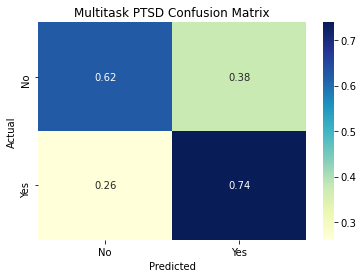

Accuracy:  0.6595744680851063


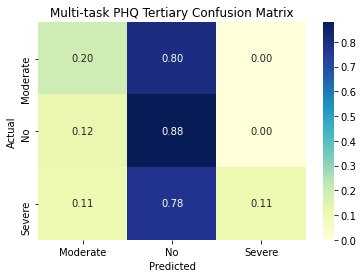

Accuracy:  0.6808510638297872


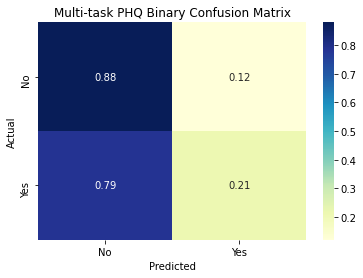

In [48]:
early_stop = True
if early_stop:
    multitask_model = MODEL_CHECKPOINT + 'multitask_early_stopping_bilstm_model.pth'
else:
    multitask_model = MODEL_CHECKPOINT + 'multitask_bilstm_model.pth'
    
# load saved best model
load_multi_model = Multi_Task_Model(vocab_size, embedding_dim, hidden_dim, embed_matrix).to(DEVICE)
load_multi_model.load_state_dict(torch.load(multitask_model))
test_loader = torch.utils.data.DataLoader(Diacwoz_Dataset(DW_test_encoded, DW_test_PHQ, DW_test_PTSD), batch_size=batch_size, shuffle=True)

#evaluate the model
actual_phq, actual_ptsd, output_phq, output_ptsd = evaluate_multi_task(load_multi_model, test_loader)

# convert range to labels
multitask_ptsd_true_label = classify_ptsd(actual_ptsd)
multitask_ptsd_pred_label = classify_ptsd(output_ptsd)

multitask_binary_phq_true_label = classify_phq(actual_phq, 'Two')
multitask_tertiary_phq_true_label = classify_phq(actual_phq, 'Three')
multitask_binary_phq_pred_label = classify_phq(output_phq, 'Two')
multitask_tertiary_phq_pred_label = classify_phq(output_phq, 'Three')

# Plot confusion matrix and performance metrics report
target_names = ["No", "Yes"]
title = "Multitask PTSD Confusion Matrix"
report_name = "Multitask_PTSD_Metrics.txt"
task = "PTSD"
print_accuracy(multitask_ptsd_true_label, multitask_ptsd_pred_label)
plot_cm(multitask_ptsd_true_label, multitask_ptsd_pred_label, target_names, title, "Multitask_"+task, "")
get_classification_report(multitask_ptsd_true_label, multitask_ptsd_pred_label, target_names, target_names, report_name)
    

target_names = ["Moderate", "No", "Severe"]
title = "Multi-task PHQ Tertiary Confusion Matrix"
report_name = "Multitask_Tertiary_PHQ_Metrics.txt"
task = "PHQ"
print_accuracy(multitask_tertiary_phq_true_label, multitask_tertiary_phq_pred_label)
plot_cm(multitask_tertiary_phq_true_label, multitask_tertiary_phq_pred_label, target_names, title, "Multitask_"+task, 'Tertiary')
get_classification_report(multitask_tertiary_phq_true_label, multitask_tertiary_phq_pred_label, target_names, target_names, report_name)

target_names = ["No", "Yes"]
title = "Multi-task PHQ Binary Confusion Matrix"
report_name = "Multitask_Binary_PHQ_Metrics.txt"
task = "PHQ"

print_accuracy(multitask_binary_phq_true_label, multitask_binary_phq_pred_label)
plot_cm(multitask_binary_phq_true_label, multitask_binary_phq_pred_label, target_names, title, "Multitask_"+task, "Binary")
get_classification_report(multitask_binary_phq_true_label, multitask_binary_phq_pred_label, target_names, target_names, report_name)
    

## Transfer learning Approach:

Here, we are using the best model pre-trained on PHQ task of DIAC-WOZ dataset, and retraining it again on ANONYMITY dataset. We are using the same embeddings and vocabulary from DIAC-WOZ and retraining the base and head of the Bi-LSTM model

### Execute PHQ task Training For Anonymity:

This following cell contains code required for retraining the single task model on Anonymity dataset.

**Flow:**
* Adjust hyper parameters
* Load the pre-trained model trained on DIAC-WOZ
* Define model, optimizer and loss function
* Create Dataloaders
* Train the model and save it
* Plot and save loss curves


Training started...

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch :  1
Adjusting learning rate of group 0 to 1.0000e-03.
Train loss: 0.087 Val loss: 0.113
-------------------------------------------------------------------------------
Epoch :  2
Adjusting learning rate of group 0 to 1.0000e-03.
Train loss: 0.093 Val loss: 0.114
-------------------------------------------------------------------------------
Epoch :  3
Adjusting learning rate of group 0 to 1.0000e-03.
Train loss: 0.094 Val loss: 0.122
-------------------------------------------------------------------------------
Epoch :  4
Adjusting learning rate of group 0 to 1.0000e-03.
Train loss: 0.096 Val loss: 0.119
-------------------------------------------------------------------------------
Epoch :  5
Adjusting learning rate of group 0 to 1.0000e-03.
Train loss: 0.095 Val loss: 0.130
-------------------------------------------------------------------------------
Epoch :  6
Adjusting learning rate of group 0 to 1.000

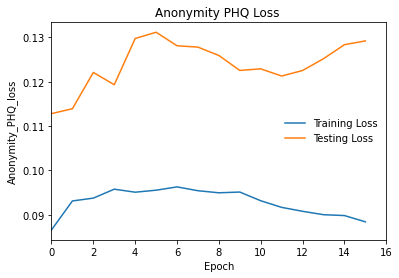

In [62]:
# Non-tuneable parameters
vocab_size = 8360
embedding_dim = 300

# Tuneable parameters
hidden_dim = 128
lr = 1e-3
epochs = 300
batch_size = 32
earlystop = True

if earlystop:
    path = MODEL_CHECKPOINT + 'singletask_PHQ_early_stopping_bilstm_model.pth'
else:
    path = MODEL_CHECKPOINT + 'singletask_PHQ_bilstm_model.pth'

# load saved singletask phq model
model_task = Single_Task_Model(vocab_size, embedding_dim, hidden_dim, embed_matrix).to(DEVICE)
model_task.load_state_dict(torch.load(path))

optimizer = torch.optim.Adam(model_task.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(DEVICE) 

train_loader = torch.utils.data.DataLoader(Anonymity_Dataset(AN_train_encoded, AN_train_PHQ), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(Anonymity_Dataset(AN_test_encoded, AN_test_PHQ), batch_size=batch_size, shuffle=True)

# train on Anonymity dataset
model_task, losses, epoch_val = Anonymity_train(model_task, optimizer, criterion, train_loader, test_loader, epochs)

# Save model
torch.save(model_task.state_dict(), MODEL_CHECKPOINT + 'Anonymity_bilstm_model.pth')

# plot loss curves
curve_name = "Anonymity_PHQ_loss" 
title = "Anonymity PHQ Loss "

draw_training_curves(losses['train'],losses['val'], curve_name, title, epoch_val)



### Executable PHQ task Evaluation for ANONYMITY

**Flow:**
* Load saved best model
* Evaluate task i.e generate predictions on test set
* Convert range into classes
* Plot confusion matrix, f1-score, recall, accuracy and precision

Accuracy:  0.8157894736842105


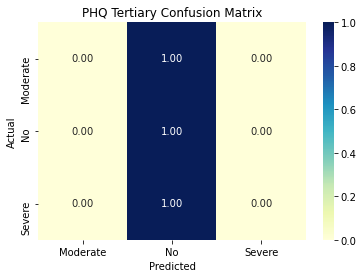

Accuracy:  0.8157894736842105


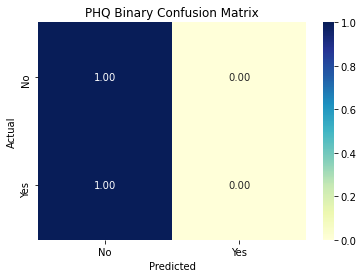

In [61]:

saved_model_path  = MODEL_CHECKPOINT + 'Anonymity_bilstm_model.pth'

loaded_model = Single_Task_Model(vocab_size, embedding_dim, hidden_dim, embed_matrix).to(DEVICE)
loaded_model.load_state_dict(torch.load(saved_model_path))

actual, predicted = Anonymity_evaluate(loaded_model, test_loader)

binary_phq_true_label = classify_phq(actual, 'Two')
binary_phq_pred_label = classify_phq(predicted, 'Two')

tertiary_phq_true_label = classify_phq(actual, 'Three')    
tertiary_phq_pred_label = classify_phq(predicted, 'Three')

target_names = ["Moderate", "No", "Severe"]
title = "PHQ Tertiary Confusion Matrix"

report_name = "Anonymity_PHQ_Tertiary_Metrics.txt"

print_accuracy(tertiary_phq_true_label, tertiary_phq_pred_label)
plot_cm(tertiary_phq_true_label, tertiary_phq_pred_label, target_names, title, "Anonymity", 'Tertiary')
get_classification_report(tertiary_phq_true_label, tertiary_phq_pred_label, target_names, target_names, report_name)

target_names = ["No", "Yes"]
title = "PHQ Binary Confusion Matrix"
report_name = "Singletask_PHQ_Binary_Metrics.txt"

print_accuracy(binary_phq_true_label, binary_phq_pred_label)
plot_cm(binary_phq_true_label, binary_phq_pred_label, target_names, title, "Anonymity", "Binary")
get_classification_report(binary_phq_true_label, binary_phq_pred_label, target_names, target_names, report_name)



In [ ]:
"""
Single Model:

    Early stopping model:

        PTSD - 66%
        PHQ  - 64% (Tertiary)
        PHQ  - 66% (Binary)

    Normal model:

        PTSD - 66%
        PHQ  - 61% (Tertiary)
        PHQ  - 66% (Binary)

Multi Model:

    Early stopping model:

        PTSD - 68%
        PHQ  - 66% (Tertiary)
        PHQ  - 68% (Binary)

    Normal model:

        PTSD - 54%
        PHQ  - 70% (Tertiary)
        PHQ  - 70% (Binary)


"""

1. Bilstm - Multitask single task and trasfer learning - Regression
2. GRU - Multitask single task and trasfer learning - Regression
3. Classification+regression